# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [5]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [22]:
import pickle


with open('../preprocessing/sdt/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

In [51]:
err_start_ind = int(.9 * len(sdts_train))

sdts_err = sdts_train[err_start_ind:]
sdts_train = sdts_train[:err_start_ind]

targets_err_true = targets_train[err_start_ind:]
targets_train = targets_train[:err_start_ind]

Initialize the CGCNN `net` class

In [34]:
from torch.optim import Adam
import torch
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

# Training

We can train a new model...

In [ ]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.4992        0.5059     +  12.4081
      2        0.2944        0.6004        12.3168
      3        0.2544        0.3860     +  12.2828
      4        0.2630        0.2554     +  12.2862
      5        0.2431        0.2448     +  12.2394
      6        0.2623        0.2849        12.3199
      7        0.2519        0.2500        12.1701
      8        0.2508        0.2341     +  12.2372
      9        0.2270        0.2825        12.2982
     10        0.2268        0.2359        12.2340
     11        0.2247   

...or load whatever is cached

In [42]:
net.initialize()
net.load_params(f_history='valid_best_history.json',
                f_optimizer= 'valid_best_optimizer.pt', 
                f_params='valid_best_params.pt')

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.


# Second CGCNN to Predict Error on Held Out Data

In [ ]:
# Use CGCNN-1 to predict targets for sdts_err
# Find errors (difference) with targets_err_true, and define this difference to be targets_err
# Then: Train CGCNN on data (sdts_err, targets_err)


In [49]:
# Imports
import numpy as np

In [43]:
# Use CGCNN-1 to predict targets for sdts_err
targets_err_pred = net.predict(sdts_err).reshape(-1)

In [88]:
# Find errors (difference) with targets_err_true, and define this difference to be targets_err
targets_err = np.abs(targets_err_pred.flatten() - targets_err_true.flatten()).reshape(-1,1)

In [92]:
# Callback to checkpoint parameters every time there is a new best for error-set loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='err_best_') #### TODO: confirm this

# Callback to load the checkpoint with the best error-set loss at the end of training
class train_end_load_best_err_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('err_best_params.pt')
load_best_err_loss = train_end_load_best_err_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net_err = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_err_loss, LR_schedule]
)

In [93]:
# Train CGCNN on data (sdts_err, targets_err)
net_err.initialize()
net_err.fit(sdts_err, targets_err)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6108        0.5682     +  1.0247
      2        0.1705        0.1870     +  1.0504
      3        0.1396        0.0878     +  0.9928
      4        0.1341        0.0712     +  0.9837
      5        0.1018        0.0930        0.9818
      6        0.1078        0.0790        1.0039
      7        0.0969        0.0908        0.9894
      8        0.0908        0.0783        0.9766
      9        0.0925        0.0817        0.9730
     10        0.0701        0.0749        0.9836
     11        0.0936        0.0757        0.9737
     12        0.0769        0.0713        0.9799
     13        0.0557        0.0720        0.9805
     14        0.0694        0.0726        0.9755
     15        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [94]:
net_err.initialize()
net_err.load_params(f_history='err_best_history.json',
                f_optimizer= 'err_best_optimizer.pt', 
                f_params='err_best_params.pt')

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.


In [95]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [52]:
## Get CGCNN predictions on sdts_val, and sdts_train
# targets_pred = net.predict(sdts_val).reshape(-1)
# targets_pred_train = net.predict(sdts_train).reshape(-1)

MAE = 0.18 eV
RMSE = 0.36 eV
R^2 = 0.72


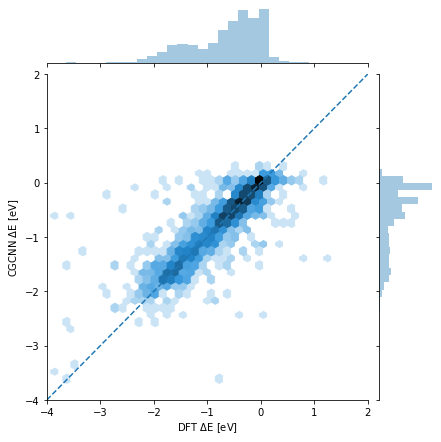

In [96]:
# Calculate the error metrics
targets_pred = net.predict(sdts_val).reshape(-1)
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
print('MAE = %.2f eV' % mae)
print('RMSE = %.2f eV' % rmse)
print('R^2 = %.2f' % r2)

# Plot
lims = [-4, 2]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
_ = grid.ax_joint.set_xlim(lims)
_ = grid.ax_joint.set_ylim(lims)
_ = grid.ax_joint.plot(lims, lims, '--')
_ = grid.ax_joint.set_xlabel('DFT $\Delta$E [eV]')
_ = grid.ax_joint.set_ylabel('CGCNN $\Delta$E [eV]')

In [99]:
# Predict errors on sdts_val (validation set)
targets_pred_err = net_err.predict(sdts_val).reshape(-1)

In [108]:
# Calibration

import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


residuals = targets_pred.flatten() - targets_val.flatten()
standard_errors = targets_pred_err

def calculate_density(percentile):
    num_within_quantile = 0
    for se, resid in zip(standard_errors, residuals):
        norm = stats.norm(loc=0, scale=se)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

Calibration factor = -0.22
Sharpness = 0.05 eV


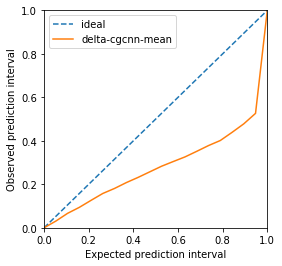

In [109]:
# Plotting Calibration

%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import seaborn as sns


# Plot the calibration curve
fig = plt.figure(figsize=(4, 4))
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label='delta-cgcnn-mean')
_ = ax_gp.set_xlabel('Expected prediction interval')
_ = ax_gp.set_ylabel('Observed prediction interval')
_ = ax_gp.set_xlim([0, 1])
_ = ax_gp.set_ylim([0, 1])

# Report the calibration factor
actual_calibration_area = integrate.trapz(y=observed_pi, x=predicted_pi)
ideal_calibration_area = integrate.trapz(y=predicted_pi, x=predicted_pi)
calibration_factor = actual_calibration_area - ideal_calibration_area
print('Calibration factor = %.2f' % calibration_factor)

# Report sharpness
sharpness = np.sqrt(np.mean(standard_errors**2))
print('Sharpness = %.2f eV' % sharpness)